In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [1]:
# !rm -rf ./data
!rm -rf ./genimages
!mkdir -p ./genimages

In [2]:
import copy
import time
import tqdm
import imageio
import warnings
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from google.colab import files

warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
seed = 0

np.random.seed(seed)
_ = torch.manual_seed(seed)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device_count = torch.cuda.device_count()
torch.backends.cudnn.benchmark = True

batch_size = 1000
latent_size = 30
image_number = 100

epochs = 100
learning_rate = 0.001

print("Device :", device)
print("GPU Count :", device_count)

Device : cuda
GPU Count : 1


In [5]:
latent_vec = torch.rand(image_number, latent_size, device=device)
image_files = []

In [6]:
transforms = T.Compose(
    [
     T.ToTensor(),
    ]
)

In [7]:
train_set = MNIST(root='./data',train=True, transform=transforms, download=True)
test_set = MNIST(root='./data',train=False, transform=transforms, download=True)

In [8]:
print("Train dataset length :", len(train_set))
print("Test dataset length :", len(test_set))

Train dataset length : 60000
Test dataset length : 10000


In [9]:
data_loader = {
    'train' : DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=4*device_count, pin_memory=True),
    'test' : DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, num_workers=4*device_count, pin_memory=True),
}

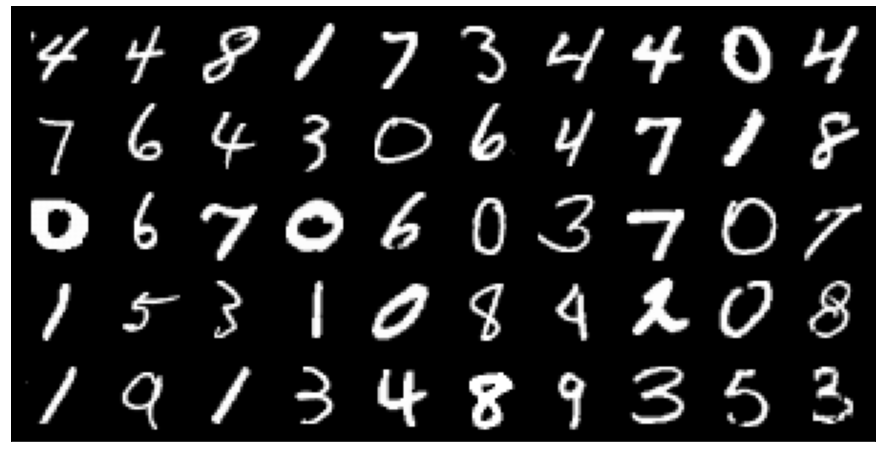

In [10]:
images, _ = next(iter(data_loader['train']))

plt.figure(figsize=(16, 8))
plt.xticks([]),
plt.yticks([])
plt.imshow(make_grid(images[:50], nrow=10, normalize=True).permute(1, 2, 0))
plt.show()

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=3, stride=1, padding=1),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=16*7*7, out_features=256),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(inplace=True),
        )
        
        self.mean = nn.Linear(in_features=64, out_features=latent_size)
        self.log_var = nn.Linear(in_features=64, out_features=latent_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(start_dim=1)
        x = self.fc_layers(x)

        mean = self.mean(x)
        log_var = self.log_var(x)
        std = torch.exp(0.5 * log_var)

        z = self.reparameterization(mean, std)
        
        return z, mean, log_var

    def reparameterization(self, mean, std):
        e = torch.rand_like(mean, device=device)
        return mean + e * std

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv_t_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(in_channels=64, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=64),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=512, out_features=784),
        )
    
    def forward(self, z):
        z = self.fc_layers(z)
        z = z.reshape(-1, 16, 7, 7)
        z = self.conv_t_layers(z)
        return z

In [13]:
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        z, mean, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [34]:
encoder, decoder = Encoder(), Decoder()
net = Net(encoder=encoder, decoder=decoder).to(device)

In [35]:
print(net)
print(f"\n{'='*50}\n")
print(f"Total number of trainable parameters : {sum(param.numel() for param in net.parameters() if param.requires_grad)}")

Net(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU(inplace=True)
    )
    (mean): Linear(in_features=64, out_features=30, bias=True)
    (log_var): Linear(in_features=64, out_features=30, bias=True)
  )
  (decode

In [15]:
def custom_loss(images, images_hat, mean, log_var):
    image_loss = F.binary_cross_entropy(images_hat, images, reduction='sum')
    kld_loss = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return image_loss + kld_loss

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [16]:
def save_outputs(index):
    net.eval()
    with torch.no_grad():
        images_hat = decoder(latent_vec)
        file_path = f'./genimages/gen-image-{index}.png'
        save_image(images_hat, file_path, nrow=int(np.sqrt(image_number)), normalize=True)
        image_files.append(imageio.imread(file_path))

save_outputs(0)

In [18]:
def train(epochs=epochs):
    
    history = {
        'loss' : {
            'train' : [],
            'test' : []
        }
    }

    width = len(str(epochs))
    best_loss = float('inf')
    best_state_dict = net.state_dict()

    train_start = time.time()
    # ------------------------------------------------
    for e in tqdm.tnrange(1, epochs+1, desc="Epochs"):
        for phase in ['train', 'test']:
            # ============================================
            running_loss = 0
            
            net.train(phase == 'train')
            with torch.set_grad_enabled(phase == 'train'):
                for images, _ in data_loader[phase]:
                    # move images to device
                    images = images.to(device)

                    # clear the gradients
                    optimizer.zero_grad()

                    # get outputs
                    images_hat, mean, log_var = net(images)

                    # get loss
                    total_loss = custom_loss(images, images_hat, mean, log_var)

                    # adjust variables
                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

                    # add to running loss
                    running_loss += total_loss.item()
                
                history['loss'][phase].append(running_loss / (len(data_loader[phase].dataset) * 1*28*28))
            
            # ============================================
        
        # save output images
        save_outputs(e)
        
        # set best test loss value and copy best state dict
        if history['loss']['test'][-1] < best_loss:
            best_loss = history['loss']['test'][-1]
            best_state_dict = copy.deepcopy(net.state_dict())
        
        if (e%5 == 0) or (e == epochs):
            print(
                f"Epoch[{e:0{width}}/{epochs}] :: "
                f"Train Loss = {history['loss']['train'][-1]:.4f}, "
                f"Test Loss = {history['loss']['test'][-1]:.4f}"
            )

    # ---------------------------------------------------
    train_end = time.time()

    # load best state dict
    net.load_state_dict(best_state_dict)

    total_time = int(train_end - train_start)
    
    return total_time, history

In [19]:
total_time, history = train(epochs=epochs)

Epoch[005/100] :: Train Loss = 0.2104, Test Loss = 0.2652
Epoch[010/100] :: Train Loss = 0.1514, Test Loss = 0.1446
Epoch[015/100] :: Train Loss = 0.1296, Test Loss = 0.1271
Epoch[020/100] :: Train Loss = 0.1209, Test Loss = 0.1189
Epoch[025/100] :: Train Loss = 0.1160, Test Loss = 0.1161
Epoch[030/100] :: Train Loss = 0.1126, Test Loss = 0.1115
Epoch[035/100] :: Train Loss = 0.1104, Test Loss = 0.1095
Epoch[040/100] :: Train Loss = 0.1083, Test Loss = 0.1083
Epoch[045/100] :: Train Loss = 0.1072, Test Loss = 0.1078
Epoch[050/100] :: Train Loss = 0.1057, Test Loss = 0.1054
Epoch[055/100] :: Train Loss = 0.1046, Test Loss = 0.1049
Epoch[060/100] :: Train Loss = 0.1041, Test Loss = 0.1046
Epoch[065/100] :: Train Loss = 0.1031, Test Loss = 0.1025
Epoch[070/100] :: Train Loss = 0.1021, Test Loss = 0.1014
Epoch[075/100] :: Train Loss = 0.1014, Test Loss = 0.1016
Epoch[080/100] :: Train Loss = 0.1008, Test Loss = 0.1010
Epoch[085/100] :: Train Loss = 0.1010, Test Loss = 0.1009
Epoch[090/100]

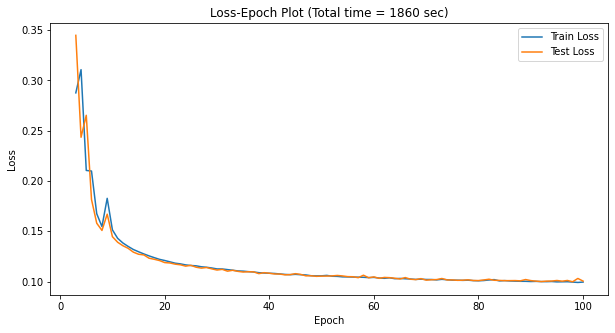

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(range(3, epochs+1), history['loss']['train'][2:], label="Train Loss")
plt.plot(range(3, epochs+1), history['loss']['test'][2:], label="Test Loss")
plt.title(f"Loss-Epoch Plot (Total time = {total_time} sec)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss-epoch.png")
plt.show()

In [21]:
imageio.mimsave('./gen-images-gif.gif',image_files, duration=0.5)

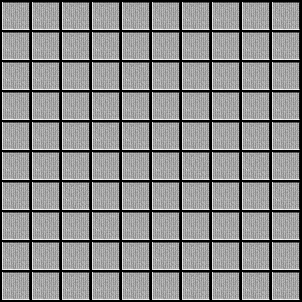

In [22]:
Image(open('./gen-images-gif.gif', 'rb').read(), width=800, height=800)

In [26]:
def plot_predict_image(model, file_name):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader['test']))
        images = images[:10] # batch of ten images
        images = images.to(device)
        images_hat, _, _ = model(images)
        
        plt.figure(figsize=(20, 4))
        
        plt.subplot(2, 1, 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(make_grid(images.cpu(), nrow=10, normalize=True).permute(1, 2, 0))

        plt.subplot(2, 1, 2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(make_grid(images_hat.cpu(), nrow=10, normalize=True).permute(1, 2, 0))

        plt.savefig(file_name)
        
        plt.show()

In [27]:
def plot_outout_image(model, file_name):
    model.eval()
    with torch.no_grad():
        images_hat = model(torch.rand(100, latent_size, device=device))
        plt.figure(figsize=(10, 10))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(make_grid(images_hat.cpu(), nrow=10, normalize=True).permute(1, 2, 0))
        
        plt.savefig(file_name)

        plt.show()

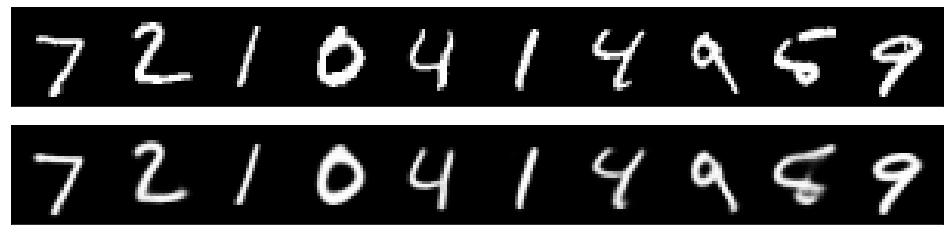

In [28]:
plot_predict_image(net, 'gen-predict-image.png')

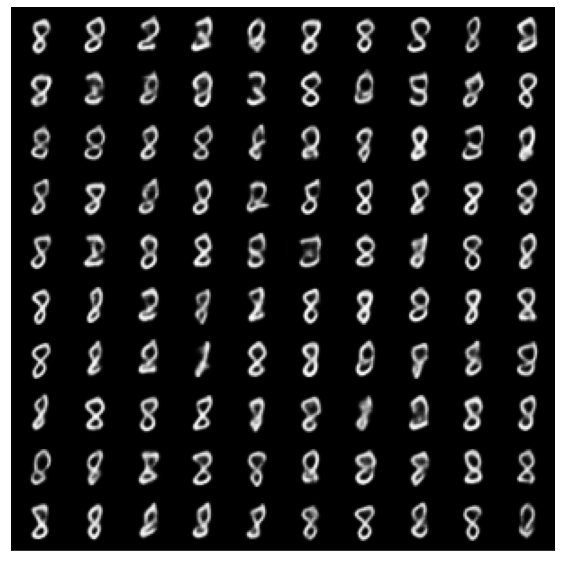

In [29]:
plot_outout_image(decoder, 'gen-output-image.png')

In [33]:
checkpoint = {
    'net' : {
        'model' : Net(encoder, decoder),
        'state_dict' : net.state_dict(),
    },
}
torch.save(checkpoint, 'checkpoint.pth')

In [36]:
files.download("checkpoint.pth")
files.download("loss-epoch.png")
files.download("gen-images-gif.gif")
files.download("gen-output-image.png")
files.download("gen-predict-image.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>